In [ ]:
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from scipy.cluster.vq import kmeans, vq
from numpy.linalg import norm
import joblib

In [ ]:
plt.rcParams["image.cmap"] = "gray"

data = glob(r"./images/*/*.jpg")
print(f"Total images found: {len(data)}")

Total images found: 3613


In [ ]:
# Load images into memory
data1 = []
for i in range(len(data)):
    data1.append(cv.imread(data[i], 1))


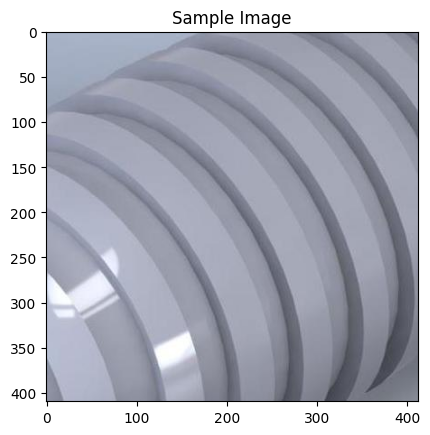

In [ ]:
# Display a sample image
plt.imshow(data1[0][:, :, ::-1])
plt.title("Sample Image")
plt.show()


In [ ]:

# Convert images to grayscale
bw_images = []
for img in data1:
    if len(img.shape) == 3:
        bw_images.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    else:
        bw_images.append(img)


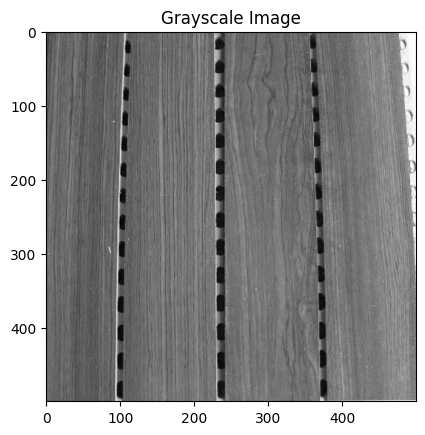

In [ ]:

# Display a grayscale image
plt.imshow(bw_images[1])
plt.title("Grayscale Image")
plt.show()

In [ ]:
# Extract SIFT features
extractor = cv.SIFT_create()
keypoints = []
descriptors = []
for img in bw_images:
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [ ]:
# Remove images with no descriptors
to_drop = [i for i, img_descriptors in enumerate(descriptors) if img_descriptors is None]
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"Total descriptors after cleanup: {len(descriptors)}")


Total descriptors after cleanup: 3543


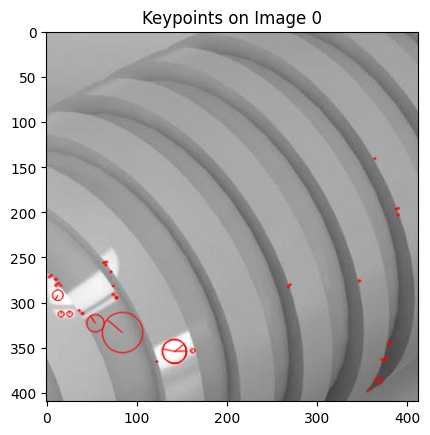

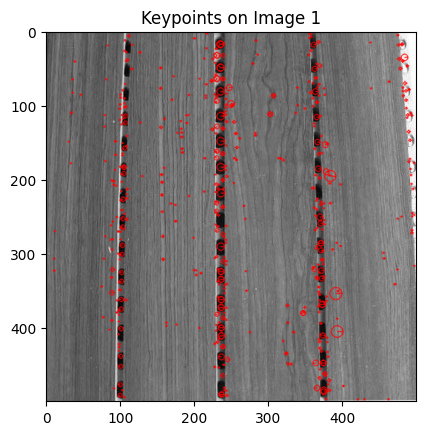

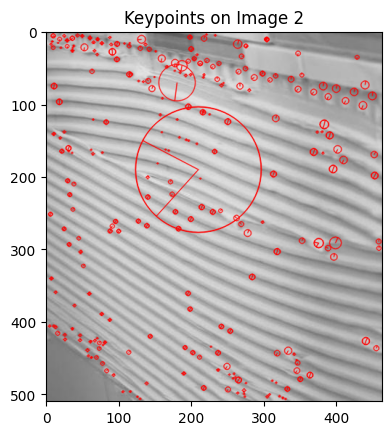

In [ ]:
# Visualize keypoints on sample images
output_image = []
for x in range(3):
    output_image.append(cv.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x])
    plt.title(f"Keypoints on Image {x}")
    plt.show()

In [ ]:
# Sample descriptors for K-Means clustering
np.random.seed(0)
sample_idx = np.random.randint(0, len(descriptors), 500).tolist()  # Adjust sample size
descriptors_sample = [descriptors[n] for n in sample_idx]


In [ ]:
# Stack all descriptors for clustering
all_descriptors = np.vstack(descriptors_sample)
print(f"Shape of all descriptors: {all_descriptors.shape}")


Shape of all descriptors: (1145750, 128)


In [ ]:
def cluster_descriptors(all_descriptors, k=250, iters=4):
    codebook, variance = kmeans(all_descriptors, k, iters)
    return codebook

In [ ]:
# Quantize image features
def quantize_features(descriptors, codebook):
    visual_words = []
    for img_descriptors in descriptors:
        img_visual_words, _ = vq(img_descriptors, codebook)
        visual_words.append(img_visual_words)
    return visual_words


In [ ]:
# Compute frequency vectors
def compute_frequency_vectors(visual_words, k):
    frequency_vectors = []
    for img_visual_words in visual_words:
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)
    return np.stack(frequency_vectors)


In [ ]:
# Compute TF-IDF vectors
def compute_tfidf(frequency_vectors, N):
    df = np.sum(frequency_vectors > 0, axis=0)
    idf = np.log(N / df)
    tfidf = frequency_vectors * idf
    return tfidf


In [ ]:
# Compute cosine similarity
def cosine_similarity(query_vector, vectors):
    return np.dot(query_vector, vectors.T) / (norm(query_vector) * norm(vectors, axis=1))

In [ ]:
# Search for similar images
def search(query_idx, tfidf, top_k=5):
    query_vector = tfidf[query_idx]
    similarity_scores = cosine_similarity(query_vector, tfidf)
    top_indices = np.argsort(-similarity_scores)[:top_k]
    return top_indices, similarity_scores

In [ ]:
# Visualize search results
def visualize_search_results(query_idx, top_indices, bw_images):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(top_indices) + 1, 1)
    plt.imshow(bw_images[query_idx])
    plt.title("Query Image")
    plt.axis('off')

    for i, idx in enumerate(top_indices):
        plt.subplot(1, len(top_indices) + 1, i + 2)
        plt.imshow(bw_images[idx])
        plt.title(f"Result {i + 1}")
        plt.axis('off')
    plt.show()

In [ ]:
# Experiment 1: Varying the number of images for centroids
def experiment_vary_sample_size(sample_sizes, descriptors, k=250):
    for size in sample_sizes:
        print(f"Running experiment with sample size: {size}")
        sample_idx = np.random.randint(0, len(descriptors), size).tolist()
        descriptors_sample = [descriptors[n] for n in sample_idx]
        all_descriptors = np.vstack(descriptors_sample)
        codebook = cluster_descriptors(all_descriptors, k)
        visual_words = quantize_features(descriptors, codebook)
        frequency_vectors = compute_frequency_vectors(visual_words, k)
        tfidf = compute_tfidf(frequency_vectors, len(descriptors))
        top_indices, similarity_scores = search(0, tfidf)
        visualize_search_results(0, top_indices, bw_images)

# Experiment 2: Varying the number of centroids
def experiment_vary_centroids(k_values, all_descriptors, descriptors):
    for k in k_values:
        print(f"Running experiment with k={k}")
        codebook = cluster_descriptors(all_descriptors, k)
        visual_words = quantize_features(descriptors, codebook)
        frequency_vectors = compute_frequency_vectors(visual_words, k)
        tfidf = compute_tfidf(frequency_vectors, len(descriptors))
        top_indices, similarity_scores = search(0, tfidf)
        visualize_search_results(0, top_indices, bw_images)

# Experiment 3: Comparing TF-IDF and BoW
def experiment_tfidf_vs_bow(descriptors, codebook):
    visual_words = quantize_features(descriptors, codebook)
    frequency_vectors = compute_frequency_vectors(visual_words, codebook.shape[0])
    tfidf = compute_tfidf(frequency_vectors, len(descriptors))
    bow = frequency_vectors  # BoW is just frequency vectors without TF-IDF

    # Search using TF-IDF
    top_indices_tfidf, similarity_scores_tfidf = search(0, tfidf)
    print("TF-IDF Results:")
    visualize_search_results(0, top_indices_tfidf, bw_images)

    # Search using BoW
    top_indices_bow, similarity_scores_bow = search(0, bow)
    print("BoW Results:")
    visualize_search_results(0, top_indices_bow, bw_images)

In [ ]:
def main():
    # Experiment 1: Vary sample size
    sample_sizes = [100, 500, 1000]
    experiment_vary_sample_size(sample_sizes, descriptors)

    # Experiment 2: Vary number of centroids
    k_values = [100, 250, 500]
    experiment_vary_centroids(k_values, all_descriptors, descriptors)

    # Experiment 3: Compare TF-IDF and BoW
    codebook = cluster_descriptors(all_descriptors, k=250)
    experiment_tfidf_vs_bow(descriptors, codebook)

Running experiment with sample size: 100


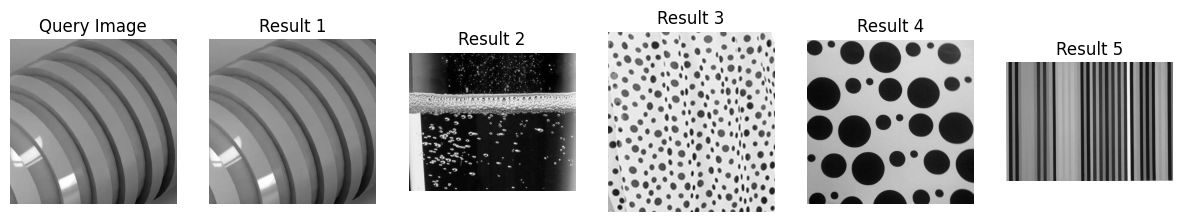

Running experiment with sample size: 500


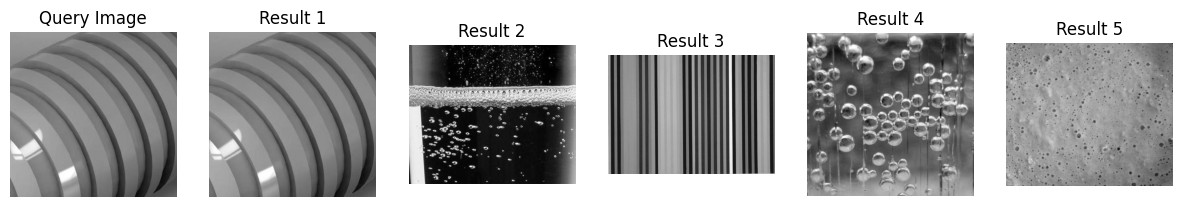

In [ ]:
# Experiment 1: Vary sample size
sample_sizes = [100, 500, 1000]
experiment_vary_sample_size(sample_sizes, descriptors)

In [ ]:
sample_sizes = [750]
experiment_vary_sample_size(sample_sizes, descriptors)

Running experiment with k=100


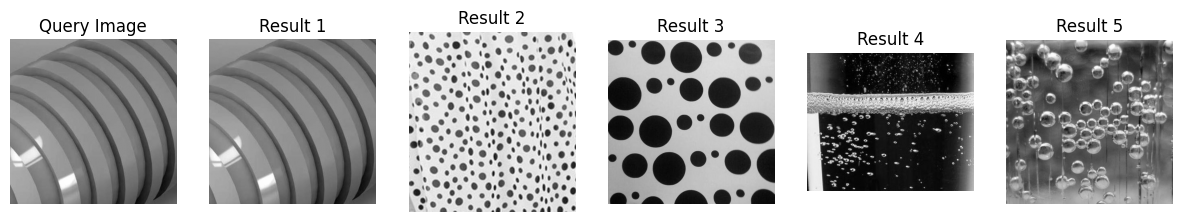

Running experiment with k=250


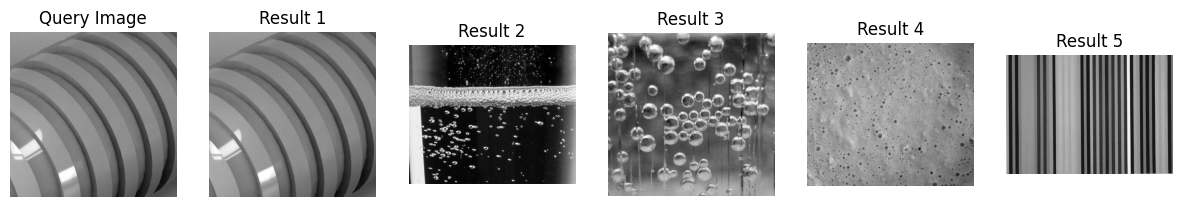

In [ ]:
# Experiment 2: Vary number of centroids
k_values = [100, 250, 500]
experiment_vary_centroids(k_values, all_descriptors, descriptors)

TF-IDF Results:


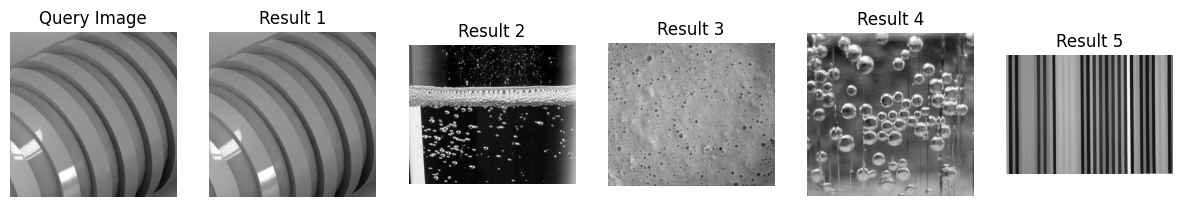

BoW Results:


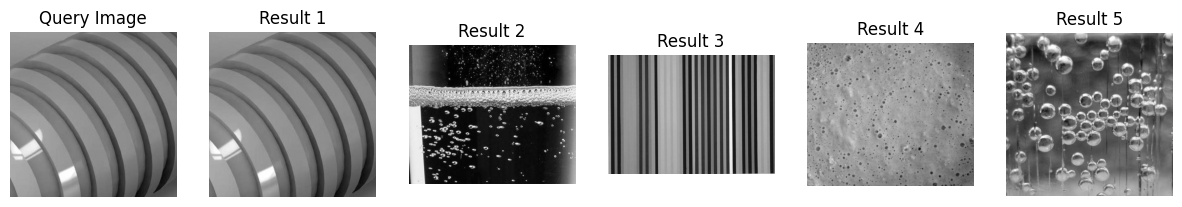

In [ ]:
# Experiment 3: Compare TF-IDF and BoW
codebook = cluster_descriptors(all_descriptors, k=250)
experiment_tfidf_vs_bow(descriptors, codebook)